In [0]:
%%time 

# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet

# Install geovisualization libraries
!pip install folium  --quiet
!pip install plotly_express  --quiet
!pip install mapclassify --quiet

# Install Pysal - Spatial Statistics
!pip install pysal --quiet
!pip install splot --quiet

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 14 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2

In [0]:
# Importing libraries
import pandas as pd 
import numpy as np
import geopandas as gpd
import fiona


import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import folium 
import plotly
import plotly_express as px

from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from esda.geary import Geary
from esda.getisord import G
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from esda.getisord import G_Local
from splot.esda import lisa_cluster
from pysal.explore import esda
from pysal.lib import weights
import pysal as ps

/usr/local/lib/python3.6/dist-packages/pysal/explore/segregation/network/network.py:16: UserWarning:

You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`



In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [0]:
from google.cloud import bigquery
client = bigquery.Client('thesisprojects2019')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### London Wards Maps - Event and Venue Profile
### Statistical - Spatial Autocorrelation


In [0]:
#import london statistic table from bigquery
query = """ SELECT * FROM `thesisprojects2019.audeMS.step10_eventtype_london_homelocation_spectatorswithhome` 
                 ORDER BY event_type, ward_id """
data = client.query(query).to_dataframe()

In [0]:
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,venue,event_type,ward_id,ward_name,count_spect_london,perc_spectators_london,venue_eventtype
0,wembley stadium,Champions League,E05000028,Becontree,1,0.04,Champions League - wembley stadium
1,wembley stadium,Champions League,E05000030,Eastbrook,3,0.12,Champions League - wembley stadium


In [0]:
#import the london shapefiles from GoogleDrive
pathdrive = 'drive/My Drive/Colab Notebooks/Shapefiles/London/London_Ward_CityMerged.shp'
geom_data = gpd.read_file(pathdrive)
geom_data.head(2)

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.5959642464 160201.8020401799,..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.9984840818 164295.60020387, 5..."


In [0]:
# CRS for London Ward
crs = {'init': 'epsg:4326'}
lnd_ward = geom_data.to_crs({'init':'epsg:27700'})

# rename the columns
lnd_ward = lnd_ward.rename(columns={'NAME':'ward_name','GSS_CODE':'ward_id'})
# Select only the columns of interest
lnd_ward = lnd_ward[['ward_name','ward_id','geometry']]

In [0]:
# Create the list of event
venue_eventtype_list = []
for i in data.venue_eventtype:
    if i not in venue_eventtype_list:
        venue_eventtype_list.append(i)

In [0]:
# Create a function to selection a subset of the dataframe - only values related to specific event!
def new_df(event_venue_type):
  data_event = data[data['venue_eventtype']==event_venue_type]
  return data_event

### GLOBAL SPATIAL AUTOCORRELATION 

In [0]:
### GLOBAL SPATIAL AUTOCORRELATION 

# create a new list to store the event name
event_name_list = []
# create lists to store the moran statistic values for each event
moran_stat_list = []
moran_expect_list = []
moran_var_list = []
moran_pvalue_list = []
moran_stdev_list = []
# create lists to store the geary statistic values for each event
geary_stat_list = []
geary_expect_list = []
geary_var_list = []
geary_pvalue_list = []
geary_stdev_list = []
# create lists to store the getis statistic values for each event
geti_stat_list = []
geti_expect_list = []
geti_var_list = []
geti_pvalue_list = []
geti_stdev_list = []

for e in venue_eventtype_list:
  # Mergedata
  data_event = data[data['venue_eventtype']==e]
  
  datajoin = pd.merge(data_event,lnd_ward,how='right',on=['ward_id'])
  datajoin = datajoin[['venue','event_type','venue_eventtype','ward_id','ward_name_x','perc_spectators_london','geometry']]
  
  # select the event name
  eventname = datajoin['venue_eventtype'][0]
  event_name_list.append(eventname) 

  # change to gdp
  gpd_df = gpd.GeoDataFrame(datajoin, geometry='geometry', crs={'init': 'epsg:27700'})
     
  # If NaN -> change it to 0!   
  values = {'venue': 0, 'event_type':0,'perc_spectators_london':0}  
  gpd_df = gpd_df.fillna(value=values)
  
  # Create y variable values for the event - percentage spectators per ward!
  ye = gpd_df['perc_spectators_london'].values

  # Get Weights (Queen) - standardize them -- Spatial Weight Matrix
  wqs = Queen.from_dataframe(gpd_df)
  wqs.transform = 'r'
    
  # Calculate Moran's I - Global Spatial Autocorrelation
  # Do we have clustered values (close to 1) or dispersed values (close to -1)
  moran = Moran(ye, wqs)
  moran_statistic = moran.I
  moran_stat_list.append(moran_statistic)
  
  # Moran Expected Value under normality assumption
  moran_expected = moran.EI
  moran_expect_list.append(moran_expected)
  
  # Moran Variance Value under normality assumption
  moran_var = moran.VI_norm
  moran_var_list.append(moran_var)
  
  # Moran p-value under normality assumption  
  moran_pvalue = moran.p_norm  
  moran_pvalue_list.append(moran_pvalue)  
  
  # Moran Standard Deviation Value under normality assumption
  moran_stdev = moran.seI_norm
  moran_stdev_list.append(moran_stdev)
    
  
  # Calculate Geary's C - Global Spatial Autocorrelation
  # Do similar values clustered or do dissimilar values clustered?
  geary = Geary(ye, wqs)  
  geary_statistic = geary.C
  geary_stat_list.append(geary_statistic)
  
  # Geary's C Expected Value under normality assumption
  geary_expected = geary.EC
  geary_expect_list.append(geary_expected)
  
   # Geary's C Expected Value under normality assumption
 # geary_var = geary.VC
 # geary_var_list.append(geary_var)
  
  # Geary's C p-value under normality assumption  
  geary_pvalue = geary.p_norm  
  geary_pvalue_list.append(geary_pvalue) 
  
  # Geary's C Standard Normal Test Statistic under normality assumption
  geary_stdev = geary.z_norm
  geary_stdev_list.append(geary_stdev)
  
  
  # Calculate Getis Ord General G. - Global Spatial Autocorrelation
  # Do High or Low values clustered? 
  # G > Expected => High values clustering | G < Expected => Low values clustering
  geti = G(ye, wqs)  
  geti_statistic = geti.G
  geti_stat_list.append(geti_statistic)
  
  #Getis Ord General G Expected Value under normality assumption
  geti_expected = geti.EG
  geti_expect_list.append(geti_expected)
  
  #Getis Ord General G Expected Value under normality assumption
  geti_var = geti.VG
  geti_var_list.append(geti_var)
  
  #Getis Ord General G p-value under normality assumption  
  geti_pvalue = geti.p_norm  
  geti_pvalue_list.append(geti_pvalue) 
  
  #Getis Ord General G Standard Normal Test Statistic under normality assumption
  geti_stdev = geti.z_norm
  geti_stdev_list.append(geti_stdev) 


In [0]:
spatial_autocorr = pd.DataFrame({'event_name_list':event_name_list,'moran_stat_list':moran_stat_list, 'moran_expect_list':moran_expect_list, 
                                 'moran_var_list':moran_var_list, 'moran_pvalue_list':moran_pvalue_list, 'moran_stdev_list':moran_stdev_list, 
                                 'geary_stat_list':geary_stat_list, 'geary_expect_list':geary_expect_list, 'geary_pvalue_list':geary_pvalue_list, 'geary_stdev_list':geary_stdev_list,
                                 'geti_stat_list':geti_stat_list, 'geti_expect_list':geti_expect_list, 'geti_var_list':geti_var_list, 'geti_pvalue_list':geti_pvalue_list, 'geti_stdev_list':geti_stdev_list})
spatial_autocorr.head(2)

,event_name_list,moran_stat_list,moran_expect_list,moran_var_list,moran_pvalue_list,moran_stdev_list,geary_stat_list,geary_expect_list,geary_pvalue_list,geary_stdev_list,geti_stat_list,geti_expect_list,geti_var_list,geti_pvalue_list,geti_stdev_list
0,Champions League - wembley stadium,0.411813,-0.001582,0.000551,0.0,0.023476,0.597743,1.0,3.428841e-60,-16.322236,0.016092,0.009324,1.919455e-07,0.0,15.449370
1,International Football - wembley stadium,0.311508,-0.001582,0.000551,0.0,0.023476,0.748577,1.0,9.724158e-25,-10.201874,0.013906,0.009324,1.182078e-07,0.0,13.327394


In [0]:
# push table to bigquery
import pandas_gbq

full_table_id = 'audeMS.spatial_autocorr_eventtype_london'
project_id = 'thesisprojects2019'

pandas_gbq.to_gbq(spatial_autocorr,full_table_id, project_id=project_id)

### LOCAL SPATIAL AUTOCORRELATION 

In [0]:
### LOCAL SPATIAL AUTOCORRELATION 

# create a new list to store the event name
event_name_list = []
# create lists to store the moran statistic values for each event
moran_local_stat_list = []
moran_local_expect_list = []
moran_local_var_list = []
moran_local_pvalue_list = []
moran_local_stdev_list = []
# create lists to store the getis statistic values for each event


for e in venue_eventtype_list:
  # Mergedata
  data_event = data[data['venue_eventtype']==e]
  
  datajoin = pd.merge(data_event,lnd_ward,how='right',on=['ward_id'])
  datajoin = datajoin[['venue','event_type','venue_eventtype','ward_id','ward_name_x','perc_spectators_london','geometry']]
  
  # select the event name
  eventname = datajoin['venue_eventtype'][0]
  event_name_list.append(eventname) 
 
  # change to gdp
  gpd_df = gpd.GeoDataFrame(datajoin, geometry='geometry', crs={'init': 'epsg:27700'})
     
  # If NaN -> change it to 0!   
  values = {'venue': 0, 'event_type':0,'perc_spectators_london':0}  
  gpd_df = gpd_df.fillna(value=values)
  
  # Create y variable values for the event - percentage spectators per ward!
  ye = gpd_df['perc_spectators_london'].values

  # Get Weights (Queen) - standardize them -- Spatial Weight Matrix
  wqs = Queen.from_dataframe(gpd_df)
  wqs.transform = 'r'
  
  # Sptial lag
  ylagg = weights.lag_spatial(wqs, ye)
  gpd_df['ylag'] = ylagg
    
  # Calculate Moran's I - Global Spatial Autocorrelation
  # Do we have clustered values (close to 1) or dispersed values (close to -1)
  moran_local = Moran_Local(ye, wqs)
  
  # Make a scatter plot of the Local Moran Statistic

 # fig, ax = plt.subplots(1,figsize=(9,9))
 # moran_scatterplot(moran_local, p=0.05, ax=ax)
 # ax.set_title(str(e)+' Moran Local Scatterplot')
  
 # plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/Local_Moran_London/Graphs/lndward_localmoran_'+str(e)+'.png')
  
  # Create a Map of the Local Moran Statistic
  fig, ax = plt.subplots(1, figsize=(9, 7),dpi=140)
  
  # create map
  lisa_cluster(moran_local,gpd_df,p=0.05,ax=ax, legend=True)
  
  plt.title('Local Moran Test - ' + str(e), fontsize=12)
  
  fig.tight_layout()
    
  plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/Local_Moran_London/Maps/lndward_localmoran_'+str(e)+'.png')
    
  plt.close('all')
 # plt.show()

In [0]:
import os
from google.colab import files

folderpath = 'drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/Local_Moran_London/Maps'

for filename in os.listdir(folderpath):
  files.download(folderpath+'/'+str(filename))

### England District Selection Maps - Event and Venue Profile
### Statistical - Spatial Autocorrelation


In [0]:
#import london statistic table from bigquery
query = """ SELECT * FROM `thesisprojects2019.audeMS.step10_eventtype_district_homelocation_spectatorswithhome` 
                 ORDER BY event_type, district_id """
data = client.query(query).to_dataframe()

NameError: ignored

In [0]:
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,venue,event_type,district_id,district_name,count_spect_district,perc_spectators_county,venue_eventtype
0,wembley stadium,Champions League,E06000004,Stockton-on-Tees,1,0.04,Champions League - wembley stadium
1,wembley stadium,Champions League,E06000015,Derby,1,0.04,Champions League - wembley stadium


In [0]:
#import the district shapefiles from GoogleDrive
pathdrive = 'drive/My Drive/Colab Notebooks/Shapefiles/District/Local_Authority_Districts_December_2017_Super_Generalised_Clipped_Boundaries_in_Great_Britain.shp'
geom_data = gpd.read_file(pathdrive)
geom_data.head(2)

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.365265e+07,59467.502291,"POLYGON ((447851.2015000004 537036.0043000001,..."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.410254e+07,38474.532954,MULTIPOLYGON (((450791.1017000005 520932.50390...


In [0]:
# CRS for London Ward
crs = {'init': 'epsg:4326'}
district = geom_data.to_crs({'init':'epsg:27700'})

# rename the columns
district = district.rename(columns={'lad17nm':'district_name','lad17cd':'district_id'})
# Select only the columns of interest
district = district[['district_id','district_name','geometry']]

In [0]:
#SELECT only the districts around London
select_district = ['South Bucks', 'Chiltern','Wycombe','Aylesbury Vale','Hastings','Rother','Wealden','Eastbourne','Lewes',
                  'Harlow','Epping Forest','Brentwood','Basildon','Castle Point','Rochford','Maldon','Chelmsford','Uttlesford','Braintree','Colchester','Tendring',
                  'Gosport','Fareham','Winchester','Havant','East Hampshire','Hart','Rushmoor','Basingstoke and Deane','Test Valley','Eastleigh','New Forest',
                  'Three Rivers','Watford','Hertsmere','Welwyn Hatfield','Broxbourne','East Hertfordshire','Stevenage','North Hertfordshire','St Albans',
                  'Dacorum','Dartford','Gravesham','Sevenoaks','Tonbridge and Malling','Tunbridge Wells','Maidstone','Swale','Ashford','Folkestone and Hythe',
                  'Canterbury','Dover','Thanet','Oxford','Cherwell','South Oxfordshire','Vale of White Horse','West Oxfordshire','Spelthorne','Runnymede', 
                  'Surrey Heath','Woking','Elmbridge','Guildford','Waverley','Mole Valley','Epsom and Ewell','Reigate and Banstead','Tandridge','Worthing',
                  'Arun','Chichester','Horsham','Crawley','Mid Sussex','Adur','City of London','Westminster','Kensington and Chelsea','Hammersmith and Fulham',
                  'Wandsworth','Lambeth','Southwark','Tower Hamlets','Hackney','Islington','Camden','Brent','Ealing','Hounslow','Richmond upon Thames',
                  'Kingston upon Thames','Merton','Sutton','Croydon','Bromley','Lewisham','Greenwich','Bexley','Havering','Barking and Dagenham',
                  'Redbridge','Newham','Waltham Forest','Haringey','Enfield','Barnet','Harrow','Hillingdon','Bracknell Forest','Reading','Slough',
                  'West Berkshire','Windsor and Maidenhead','Wokingham','Milton Keynes','Bedford','Central Bedfordshire','Luton','Southend-on-Sea',
                   'Thurrock','Medway','Brighton and Hove','Portsmouth','Southampton','South Cambridgeshire','Cambridge','Shepway']

In [0]:
# Create a new Geopandas Dataframe for only the district we are interested in!
new_gpd_list = []
for i in select_district:
    new = district[district['district_name']== i]
    new_gpd_list.append(new)
    new_gpd = pd.concat(new_gpd_list)

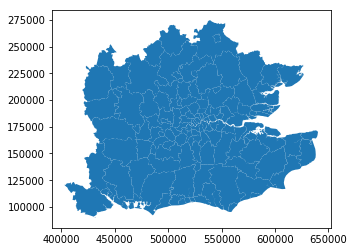

In [0]:
crs = {'init': 'epsg:4326'}
new_gpd = new_gpd.to_crs({'init':'epsg:27700'})
new_gpd.plot()

In [0]:
# Create the list of event
venue_eventtype_list = []
for i in data.venue_eventtype:
    if i not in venue_eventtype_list:
        venue_eventtype_list.append(i)

### Global Spatial Autocorrelation
#### Moran's I, Geary's C, Geti's G 

In [0]:
### GLOBAL SPATIAL AUTOCORRELATION 

# create a new list to store the event name
event_name_list = []
# create lists to store the moran statistic values for each event
moran_stat_list = []
moran_expect_list = []
moran_var_list = []
moran_pvalue_list = []
moran_stdev_list = []
# create lists to store the geary statistic values for each event
geary_stat_list = []
geary_expect_list = []
geary_var_list = []
geary_pvalue_list = []
geary_stdev_list = []
# create lists to store the getis statistic values for each event
geti_stat_list = []
geti_expect_list = []
geti_var_list = []
geti_pvalue_list = []
geti_stdev_list = []

for e in venue_eventtype_list:
  # Mergedata
  data_event = data[data['venue_eventtype']==e]
  
  datajoin = pd.merge(data_event,new_gpd,how='right',on=['district_id'])
  datajoin = datajoin[['venue','event_type','venue_eventtype','district_id','district_name_x','perc_spectators_county','geometry']]
  
  # select the event name
  eventname = datajoin['venue_eventtype'][0]
  event_name_list.append(eventname) 

  # change to gdp
  gpd_df = gpd.GeoDataFrame(datajoin, geometry='geometry', crs={'init': 'epsg:27700'})
     
  # If NaN -> change it to 0!   
  values = {'venue': 0, 'event_type':0,'perc_spectators_county':0}  
  gpd_df = gpd_df.fillna(value=values)
  
  # Create y variable values for the event - percentage spectators per ward!
  ye = gpd_df['perc_spectators_county'].values

  # Get Weights (Queen) - standardize them -- Spatial Weight Matrix
  wqs = Queen.from_dataframe(gpd_df)
  wqs.transform = 'r'
    
  # Calculate Moran's I - Global Spatial Autocorrelation
  # Do we have clustered values (close to 1) or dispersed values (close to -1)
  moran = Moran(ye, wqs)
  moran_statistic = moran.I
  moran_stat_list.append(moran_statistic)
  
  # Moran Expected Value under normality assumption
  moran_expected = moran.EI
  moran_expect_list.append(moran_expected)
  
  # Moran Variance Value under normality assumption
  moran_var = moran.VI_norm
  moran_var_list.append(moran_var)
  
  # Moran p-value under normality assumption  
  moran_pvalue = moran.p_norm  
  moran_pvalue_list.append(moran_pvalue)  
  
  # Moran Standard Deviation Value under normality assumption
  moran_stdev = moran.seI_norm
  moran_stdev_list.append(moran_stdev)
    
  
  # Calculate Geary's C - Global Spatial Autocorrelation
  # Do similar values clustered or do dissimilar values clustered?
  geary = Geary(ye, wqs)  
  geary_statistic = geary.C
  geary_stat_list.append(geary_statistic)
  
  # Geary's C Expected Value under normality assumption
  geary_expected = geary.EC
  geary_expect_list.append(geary_expected)
  
   # Geary's C Expected Value under normality assumption
 # geary_var = geary.VC
 # geary_var_list.append(geary_var)
  
  # Geary's C p-value under normality assumption  
  geary_pvalue = geary.p_norm  
  geary_pvalue_list.append(geary_pvalue) 
  
  # Geary's C Standard Normal Test Statistic under normality assumption
  geary_stdev = geary.z_norm
  geary_stdev_list.append(geary_stdev)
  
  
  # Calculate Getis Ord General G. - Global Spatial Autocorrelation
  # Do High or Low values clustered? 
  # G > Expected => High values clustering | G < Expected => Low values clustering
  geti = G(ye, wqs)  
  geti_statistic = geti.G
  geti_stat_list.append(geti_statistic)
  
  #Getis Ord General G Expected Value under normality assumption
  geti_expected = geti.EG
  geti_expect_list.append(geti_expected)
  
  #Getis Ord General G Expected Value under normality assumption
  geti_var = geti.VG
  geti_var_list.append(geti_var)
  
  #Getis Ord General G p-value under normality assumption  
  geti_pvalue = geti.p_norm  
  geti_pvalue_list.append(geti_pvalue) 
  
  #Getis Ord General G Standard Normal Test Statistic under normality assumption
  geti_stdev = geti.z_norm
  geti_stdev_list.append(geti_stdev) 

In [0]:
spatial_autocorr = pd.DataFrame({'event_name_list':event_name_list,'moran_stat_list':moran_stat_list, 'moran_expect_list':moran_expect_list, 
                                 'moran_var_list':moran_var_list, 'moran_pvalue_list':moran_pvalue_list, 'moran_stdev_list':moran_stdev_list, 
                                 'geary_stat_list':geary_stat_list, 'geary_expect_list':geary_expect_list, 'geary_pvalue_list':geary_pvalue_list, 'geary_stdev_list':geary_stdev_list,
                                 'geti_stat_list':geti_stat_list, 'geti_expect_list':geti_expect_list, 'geti_var_list':geti_var_list, 'geti_pvalue_list':geti_pvalue_list, 'geti_stdev_list':geti_stdev_list})
spatial_autocorr.head(2)

,event_name_list,moran_stat_list,moran_expect_list,moran_var_list,moran_pvalue_list,moran_stdev_list,geary_stat_list,geary_expect_list,geary_pvalue_list,geary_stdev_list,geti_stat_list,geti_expect_list,geti_var_list,geti_pvalue_list,geti_stdev_list
0,Champions League - wembley stadium,0.595170,-0.007874,0.003627,0.0,0.060225,0.441016,1.0,9.624328e-18,-8.49824,0.072029,0.037894,0.000012,0.0,10.000863
1,International Football - wembley stadium,0.672783,-0.007874,0.003627,0.0,0.060225,0.352337,1.0,3.551091e-23,-9.84643,0.072978,0.037894,0.000013,0.0,9.692714


In [0]:
# push table to bigquery
import pandas_gbq

full_table_id = 'audeMS.spatial_autocorr_eventtype_district_selection'
project_id = 'thesisprojects2019'

pandas_gbq.to_gbq(spatial_autocorr,full_table_id, project_id=project_id)

### Local Spatial Autocorrelation

In [0]:
### LOCAL SPATIAL AUTOCORRELATION 

# create a new list to store the event name
event_name_list = []
# create lists to store the moran statistic values for each event
moran_local_stat_list = []
moran_local_expect_list = []
moran_local_var_list = []
moran_local_pvalue_list = []
moran_local_stdev_list = []
# create lists to store the getis statistic values for each event


for e in venue_eventtype_list:
  # Mergedata
  data_event = data[data['venue_eventtype']==e]
  
  datajoin = pd.merge(data_event,new_gpd,how='right',on=['district_id'])
  datajoin = datajoin[['venue','event_type','venue_eventtype','district_id','district_name_x','perc_spectators_county','geometry']]
  
  # select the event name
  eventname = datajoin['venue_eventtype'][0]
  event_name_list.append(eventname) 
 
  # change to gdp
  gpd_df = gpd.GeoDataFrame(datajoin, geometry='geometry', crs={'init': 'epsg:27700'})
     
  # If NaN -> change it to 0!   
  values = {'venue': 0, 'event_type':0,'perc_spectators_county':0}  
  gpd_df = gpd_df.fillna(value=values)
  
  # Create y variable values for the event - percentage spectators per ward!
  ye = gpd_df['perc_spectators_county'].values

  # Get Weights (Queen) - standardize them -- Spatial Weight Matrix
  wqs = Queen.from_dataframe(gpd_df)
  wqs.transform = 'r'
  
  # Sptial lag
  ylagg = weights.lag_spatial(wqs, ye)
  gpd_df['ylag'] = ylagg
    
  # Calculate Moran's I - Global Spatial Autocorrelation
  # Do we have clustered values (close to 1) or dispersed values (close to -1)
  moran_local = Moran_Local(ye, wqs)
  
  # Make a scatter plot of the Local Moran Statistic

  fig, ax = plt.subplots(1,figsize=(9,9))
  moran_scatterplot(moran_local, p=0.05, ax=ax)
  ax.set_title(str(e)+' Moran Local Scatterplot')
  
  plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/District_LocalMoran/Graphs/'+str(e)+'district_localmoran.png')
  
  # Create a Map of the Local Moran Statistic
  fig, ax = plt.subplots(1, figsize=(9, 7),dpi=140)
#  fig, ax = plt.subplots(1, figsize=(9, 7))
  
  # create map
  lisa_cluster(moran_local,gpd_df,p=0.05,ax=ax, legend=True)
  
  plt.title('Local Moran Test - ' + str(e), fontsize=12)
  
  fig.tight_layout()
    
  plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/District_LocalMoran/Maps/'+str(e)+'district_localmoran.png')

  plt.close('all')
  #plt.show()

In [0]:
import os
from google.colab import files

folderpath = 'drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/District_LocalMoran/Maps'

for filename in os.listdir(folderpath):
  files.download(folderpath+'/'+str(filename))

In [0]:
#import london statistic table from bigquery
query = """ SELECT * FROM `thesisprojects2019.audeMS.spatial_autocorr_eventtype_district_selection` """
data = client.query(query).to_dataframe()

### Create GeoJson File

In [0]:
import pandas as pd, requests, json
import shapely.geometry
import fiona

In [0]:
# CRS for London Ward
crs = {'init': 'epsg:4326'}
lnd_ward = geom_data.to_crs({'init':'epsg:4326'})

# rename the columns
lnd_ward = lnd_ward.rename(columns={'NAME':'ward_name','GSS_CODE':'ward_id'})
# Select only the columns of interest
lnd_ward = lnd_ward[['ward_name','ward_id','geometry']]

In [0]:
data.head(1)

,venue,event_type,ward_id,ward_name,count_spect_london,perc_spectators_london,venue_eventtype
0,wembley stadium,Champions League,E05000028,Becontree,1,0.04,Champions League - wembley stadium


In [0]:
# Join Districts SHP with data_homelocation_count
jointable = pd.merge(data,lnd_ward,how='right', on=['ward_id'])
jointable = jointable[['venue','event_type','venue_eventtype','ward_id','ward_name_x','perc_spectators_london','geometry']]
jointable = jointable.sort_values('ward_id').reset_index(drop=True)
jointable['perc_spectators_london'] = round(jointable['perc_spectators_london'],3)

In [0]:
jointable.head(1)

,venue,event_type,venue_eventtype,ward_id,ward_name_x,perc_spectators_london,geometry
0,london stadium,Premier League,Premier League - london stadium,E05000026,Abbey,0.2,POLYGON ((0.08547999441580269 51.5370421145770...


In [0]:
gpd_df = gpd.GeoDataFrame(jointable, geometry='geometry', crs={'init': 'epsg:4326'})

In [0]:
gpd_df.to_file("/content/drive/My Drive/Colab Notebooks/data/london.geojson", driver='GeoJSON')

In [0]:
import os
from google.colab import files
files.download('/content/drive/My Drive/Colab Notebooks/data/london.geojson')